In [1]:
import pyising
import numpy as np
import matplotlib.pyplot as plt


In [6]:
import pyising

temps = np.linspace(1, 4, 50)

L = 64
results = pyising.run_parallel_metropolis(temps, L, N_steps=100000,
                                                   seed_base=42,
                                                   output_dir="simultion",
                                                    use_wolff=False, 
                                                    save_all_configs=False)


[==================================================] :42s<00m:00s] Running simulations...


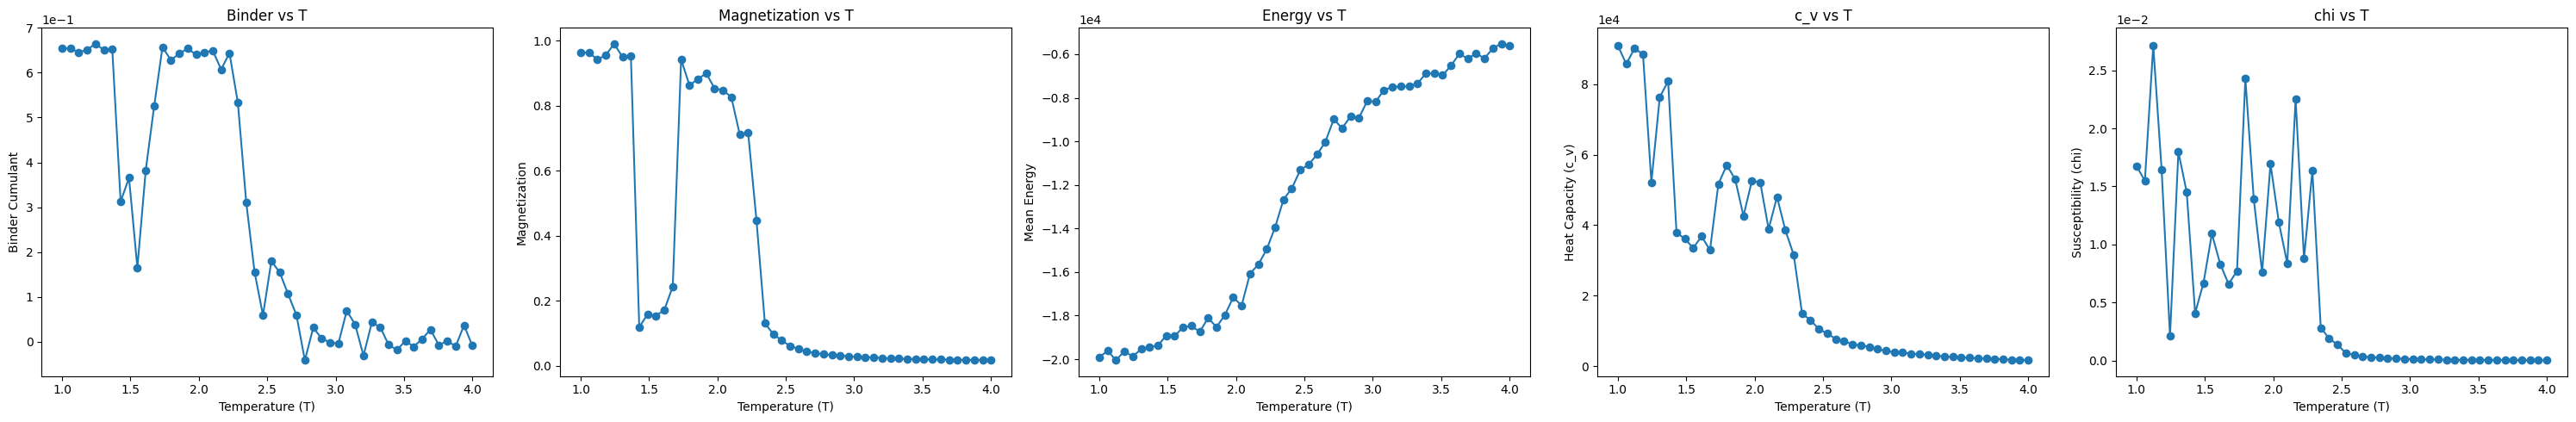

In [5]:
# For demonstration, assume we have existing simulation data in "results"
# with the following fields per temperature:
#   res.T              -> temperature
#   res.binder         -> Binder cumulant
#   res.mean_mag       -> average magnetization
#   res.mean_mag2      -> average of magnetization^2
#   res.mean_ene       -> average energy
#   res.mean_ene2      -> average of energy^2
# (and so on). We'll also show how to compute:
#   - c_v (heat capacity)
#   - chi (susceptibility)
#   - approximate error bars (if you have an estimate of measurement count, N)
# -------------------------------------------------------------------------

# Suppose you already ran the simulation:
# results = pyising.run_parallel_metropolis(...)

# We'll define a measurement count N for error estimates (if known):
# This N depends on your simulation setup (e.g., how many measurements per T).
# For demonstration, we'll assume each temperature has 100 measurements:
N = 50000.0

# Create a dictionary to store observables and any derived error estimates
data_dict = {}
for res in results:
    # Basic quantities
    T = res.T
    mean_ene = res.mean_ene
    mean_ene2 = res.mean_ene2
    mean_mag = res.mean_mag
    mean_mag2 = res.mean_mag2

    # Heat capacity: c_v = (⟨E²⟩ - ⟨E⟩²) / (k_B * T²)
    # Here we assume k_B = 1 for simplicity
    c_v = (mean_ene2 - mean_ene**2) / (T**2)

    # Susceptibility: chi = (⟨M²⟩ - ⟨M⟩²) / (k_B * T)
    # Again, assume k_B = 1
    chi = (mean_mag2 - mean_mag**2) / T

    # ------------------------------------------------------------------------
    # Approximate error bars (standard error) for demonstration:
    #   error_ene  ~ sqrt( (⟨E²⟩ - ⟨E⟩²) / N )
    #   error_mag  ~ sqrt( (⟨M²⟩ - ⟨M⟩²) / N )
    #   Similarly for c_v and chi, though real error estimations
    #   can be more sophisticated (e.g., binning or jackknife).
    # ------------------------------------------------------------------------
    energy_variance = mean_ene2 - mean_ene**2
    mag_variance = mean_mag2 - mean_mag**2

    error_ene = np.sqrt(energy_variance / N) if energy_variance >= 0 else 0.0
    error_mag = np.sqrt(mag_variance / N) if mag_variance >= 0 else 0.0

    # Approximate error propagation for c_v:
    # c_v depends on energy variance; partial deriv. approach or direct method
    # We'll do naive approach for demonstration:
    error_cv = np.sqrt( (1.0 / T**2)**2 * (2.0 * energy_variance**2 / N) )
    # This above line is a *very rough* placeholder formula.

    # Approximate error for chi:
    # chi depends on magnetization variance
    error_chi = np.sqrt( (1.0 / T)**2 * (2.0 * mag_variance**2 / N) )
    # Also a rough placeholder.

    data_dict[T] = {
        "binder": res.binder,
        "binder_err": 0.0,  # If you have binder error stored, place it here
        "magnetization": mean_mag,
        "magnetization_err": error_mag,
        "energy": mean_ene,
        "energy_err": error_ene,
        "c_v": c_v,
        "c_v_err": error_cv,
        "chi": chi,
        "chi_err": error_chi
    }

# -------------------------------------------------------------------------
# Sort the temperatures for consistent plotting
# -------------------------------------------------------------------------
sorted_temps = sorted(data_dict.keys())

# -------------------------------------------------------------------------
# Extract arrays for plotting
# -------------------------------------------------------------------------
binder_vals = [data_dict[T]["binder"] for T in sorted_temps]
binder_errs = [data_dict[T]["binder_err"] for T in sorted_temps]

mag_vals = [data_dict[T]["magnetization"] for T in sorted_temps]
mag_errs = [data_dict[T]["magnetization_err"] for T in sorted_temps]

ene_vals = [data_dict[T]["energy"] for T in sorted_temps]
ene_errs = [data_dict[T]["energy_err"] for T in sorted_temps]

cv_vals = [data_dict[T]["c_v"] for T in sorted_temps]
cv_errs = [data_dict[T]["c_v_err"] for T in sorted_temps]

chi_vals = [data_dict[T]["chi"] for T in sorted_temps]
chi_errs = [data_dict[T]["chi_err"] for T in sorted_temps]

# -------------------------------------------------------------------------
# Create subplots for multiple properties:
#   1. Binder
#   2. Magnetization
#   3. Energy
#   4. Heat Capacity (c_v)
#   5. Susceptibility (chi)
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 5, figsize=(30, 5))

# Binder vs Temperature
axes[0].errorbar(
    sorted_temps, binder_vals, yerr=binder_errs,
    marker='o', linestyle='-', ecolor='black', capsize=3
)
axes[0].set_xlabel("Temperature (T)")
axes[0].set_ylabel("Binder Cumulant")
axes[0].set_title("Binder vs T")
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Magnetization vs Temperature
axes[1].errorbar(
    sorted_temps, mag_vals, yerr=mag_errs,
    marker='o', linestyle='-', ecolor='black', capsize=3
)
axes[1].set_xlabel("Temperature (T)")
axes[1].set_ylabel("Magnetization")
axes[1].set_title("Magnetization vs T")
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Energy vs Temperature
axes[2].errorbar(
    sorted_temps, ene_vals, yerr=ene_errs,
    marker='o', linestyle='-', ecolor='black', capsize=3
)
axes[2].set_xlabel("Temperature (T)")
axes[2].set_ylabel("Mean Energy")
axes[2].set_title("Energy vs T")
axes[2].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Heat Capacity (c_v) vs Temperature
axes[3].errorbar(
    sorted_temps, cv_vals, yerr=cv_errs,
    marker='o', linestyle='-', ecolor='black', capsize=3
)
axes[3].set_xlabel("Temperature (T)")
axes[3].set_ylabel("Heat Capacity (c_v)")
axes[3].set_title("c_v vs T")
axes[3].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Susceptibility (chi) vs Temperature
axes[4].errorbar(
    sorted_temps, chi_vals, yerr=chi_errs,
    marker='o', linestyle='-', ecolor='black', capsize=3
)
axes[4].set_xlabel("Temperature (T)")
axes[4].set_ylabel("Susceptibility (chi)")
axes[4].set_title("chi vs T")
axes[4].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# -------------------------------------------------------------------------
# Adjust layout and display
# -------------------------------------------------------------------------
plt.tight_layout()
plt.show()